In [11]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error as mse
from time import perf_counter
import numpy as np

### Part 1: Prediction quality vs feature selection

#### Tasks

In this taks you are supposed to

1. repeatedly simulate new datasets and for each dataset do Steps 2 and 3 
2.  determine λ_{min} and λ_{1se} using cross-validation on the training data

3.  compare the two resulting Lasso models with respect to
    - Mean squared error on the training as well as test data
    - Feature selection quality in comparison to the original simulated regression coefficients


Let us look a bit closer at each task.

1. Simulate data
Simulating useful data for the Lasso isn't complicated but to make sure you can focus on the interesting tasks I included a Python and a R version of a data-generating function. You can either ignore them and follow the description here, use them or take them as inspiration to write your own. The ideas are

    1. Generate n observations from an isometric normal distribution $N(0,Ip)$, i.e. theoretically uncorrelated features.
    2. Generate regression coefficients beta as a vector that contains ceiling((1 - sparsity) p) non-zero elements [ceiling = closest integer less or equal to] that are normal distributed with a standard deviation of beta_scale. All other elements are zero.
    3. At this point Xβ is the noise-less response and √∥Xβ∥22/(n−1) is its sample standard deviation. Signal-to-noise ratio is a measure for the proportion of the signal (noise-less response) standard deviation to the standard deviation of the noise, i.e. SNR = sd_signal / sd_noise. Specifying the SNR is a convenient way to determine what standard deviation for the noise is reasonable by choosing sd_noise = sd_signal / SNR. As an example, SNR = 2 means that the standard deviation of the noise-less is twice as large as the standard deviation of the noise and the noise-less response will be more "pronounced" the larger the SNR is. If 0 <= SNR < 1, then the noise is stronger than the signal which is hard to deal with for most methods.
    4. Finally, the response is created in the form of a linear model y = X beta + sigma eps.

In [2]:
def simulate_data(n, p, rng, *, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    X = rng.standard_normal(size=(n, p))
    
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]

In [3]:
p = 500     # Fix p at something large, e.g. 500 or 1000
n_list = [125, 250, 375]    # Let n vary compared to p, e.g. iterate through [200, 500, 750] if you set p = 1000. What truly matters here is the ratio p / n, so if you choose p differently, adjust your choices for n
sparsities = [0.75, 0.9, 0.95, 0.99]    # Let sparsity vary for a few choices, e.g. [0.75, 0.9, 0.95, 0.99]
SNR = 2     # You can fix SNR at something reasonable like 2 or 5 throughout
beta_scale = 5      # Same holds for beta_scale, maybe 5 or 10
rng = np.random.default_rng(12345)
test_size = 500

In addition, it will help you tremendously in the interpretation of the results if you **repeat the simulations a few times**, say 5 or 10 times, for each choice of n and sparsity. Here is why you should be careful with your choices: If you chose three values for n and four for sparsity, as well as 5 repeats, then you need to run your simulations for 60 datasets. A setup with 50 datasets took about 2 minutes on a 2017 MacBook, so if it takes hours, you did something wrong :-)

It can be good to include intermediate print-outs/clock output throughout the code, e.g. for iteration numbers or cross-validation so you can detect if there is a time sink somewhere

In [52]:
x, y, beta = simulate_data(n_list[0], p, rng)

[ 0.          0.          0.          0.          0.         -4.02183271
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -2.32477544  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -6.56298455  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -9.47148727  0.
  0.          0.          0.          0.          0.          6.65848049
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.     

2. Determine hyperparameters

This works as described above the "Tasks" section. Depending on the the package you are using you will have to perform some different steps to get the coefficients and the predictions.

### 3. Comparing the two Lasso models

#### Computation of train/test MSE

Whenever you use LassoCV or cv.glmnet you can, at the best, access the test error for each fold. To compute both the training and test MSE of the model, you have two options:

1. Write your own cross validation loop. Then you can evaluate the training and test error and safe both.
2. Instead of only creating a training dataset with the options given in Part 1, Task 1 you can do the following:
    - Fix n_test at some larger value, say, n_test = 500 or n_test = 1000
    - Instead of simulating n samples you generate now n + n_test and split the dataset. Train on the n samples with cross validation and use the remaining n_test samples for testing. You do not need to adapt the size of the test set to the size of the training dataset as long as you choose it large enough.
Option 2 is probably less tedious to implement, but the choice is up to you.

When reporting the results for the train/test MSE, **please do not simply report a table of numbers. Find a nice way to visualise the results.**

#### Question
 - How does the MSE of the $λ_{min}$ and $λ_{1se}$ models behave for different n and sparsity levels?

In [124]:
from sklearn.metrics import classification_report
train_mse_min = np.empty(shape=(len(n_list), len(sparsities), 5))
train_mse_ose = np.empty(shape=(len(n_list), len(sparsities), 5))

test_mse_min = np.empty(shape=(len(n_list), len(sparsities), 5))
test_mse_ose = np.empty(shape=(len(n_list), len(sparsities), 5))

min_precision = np.empty(shape=(len(n_list), len(sparsities), 5))
ose_precision = np.empty(shape=(len(n_list), len(sparsities), 5))

min_sensitivity = np.empty(shape=(len(n_list), len(sparsities), 5))
ose_sensitivity = np.empty(shape=(len(n_list), len(sparsities), 5))

for i, n in enumerate(n_list):
    for j, sparsity in enumerate(sparsities):
        for k in range(5):

            x_full, y_full, beta = simulate_data(n+test_size, p, rng, sparsity=sparsity)
            x, y= x_full[:n], y_full[:n]
            x_test, y_test = x_full[n:], y_full[n:]

            lasso = LassoCV(cv=5).fit(x, y)
            mse_mat = lasso.mse_path_
            n_folds = mse_mat.shape[0]
            cv_mean = np.mean(mse_mat, axis=1)
            cv_std = np.std(mse_mat, axis=1)
            idx_min_mean = np.argmin(cv_mean)
            idx_alpha = np.where(
                (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
                (cv_mean >= cv_mean[idx_min_mean])
            )[0][0]
            alpha_1se = lasso.alphas_[idx_alpha]
            
            lasso_min = Lasso(alpha=lasso.alpha_).fit(x, y)
            lasso_1se = Lasso(alpha=alpha_1se).fit(x, y)

            train_min = mse(y, lasso_min.predict(x))
            train_1se = mse(y, lasso_1se.predict(x))

            beta = np.where(beta!=0, 1, 0)
            beta_min = np.where(lasso_min.coef_!=0, 1, 0)
            beta_1se = np.where(lasso_1se.coef_!=0, 1, 0)
            
            metrics = classification_report(beta, beta_min, output_dict=True)
            min_precision[i,j,k] = metrics['0']['precision'] 
            min_sensitivity[i,j,k] = metrics['0']['recall']

            metrics = classification_report(beta, beta_1se, output_dict=True)
            ose_precision[i,j,k] = metrics['0']['precision']
            ose_sensitivity[i,j,k] = metrics['0']['recall']


            train_mse_min[i,j,k] = train_min
            train_mse_ose[i,j,k] = train_1se

            test_min = mse(y_test, lasso_min.predict(x_test))
            test_1se = mse(y_test, lasso_1se.predict(x_test))

            test_mse_min[i,j,k] = test_min
            test_mse_ose[i,j,k] = test_1se
            
            
            print(f'alpha_min = {lasso.alpha_:.4f}, alpha_1se = {alpha_1se:.4f}')
            print(f'n = {n}, spar = {sparsity}, alpha_min mse = {test_min:.4f}, alpha_1se mse = {test_1se:.4f}')
            

alpha_min = 7.0752, alpha_1se = 8.7226
n = 125, spar = 0.75, alpha_min mse = 3755.3216, alpha_1se mse = 3798.2415
alpha_min = 4.2017, alpha_1se = 4.8309
n = 125, spar = 0.75, alpha_min mse = 3614.1752, alpha_1se mse = 3603.7993
alpha_min = 3.9764, alpha_1se = 6.4805
n = 125, spar = 0.75, alpha_min mse = 3377.2189, alpha_1se mse = 3467.0209
alpha_min = 16.3521, alpha_1se = 21.6165
n = 125, spar = 0.75, alpha_min mse = 3727.5196, alpha_1se mse = 3807.2385
alpha_min = 3.0100, alpha_1se = 3.9791
n = 125, spar = 0.75, alpha_min mse = 3612.7312, alpha_1se mse = 3485.2880


c:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alpha_min = 9.8333, alpha_1se = 9.8333
n = 125, spar = 0.9, alpha_min mse = 1816.1943, alpha_1se mse = 1816.1943
alpha_min = 2.0000, alpha_1se = 2.2995
n = 125, spar = 0.9, alpha_min mse = 1058.7317, alpha_1se mse = 1081.3796
alpha_min = 5.1121, alpha_1se = 5.8776
n = 125, spar = 0.9, alpha_min mse = 1258.7924, alpha_1se mse = 1322.5663
alpha_min = 2.6975, alpha_1se = 3.3255
n = 125, spar = 0.9, alpha_min mse = 1277.0966, alpha_1se mse = 1316.3519
alpha_min = 2.5713, alpha_1se = 3.9081
n = 125, spar = 0.9, alpha_min mse = 1379.2397, alpha_1se mse = 1429.6975
alpha_min = 0.8945, alpha_1se = 1.1825
n = 125, spar = 0.95, alpha_min mse = 451.5407, alpha_1se mse = 425.6031
alpha_min = 1.4060, alpha_1se = 2.1371
n = 125, spar = 0.95, alpha_min mse = 439.6242, alpha_1se mse = 459.9258
alpha_min = 1.3699, alpha_1se = 2.0821
n = 125, spar = 0.95, alpha_min mse = 501.4683, alpha_1se mse = 495.4221
alpha_min = 1.4797, alpha_1se = 2.0975
n = 125, spar = 0.95, alpha_min mse = 493.0922, alpha_1se ms

In [58]:
print(len(lasso_1se.coef_[lasso_1se.coef_==0])/len(lasso_1se.coef_))
print(len(lasso_1se.coef_))

0.98
500
[ 0.          0.          0.          0.          0.         -4.02183271
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -2.32477544  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -6.56298455  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -9.47148727  0.
  0.          0.          0.          0.          0.          6.65848049
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.


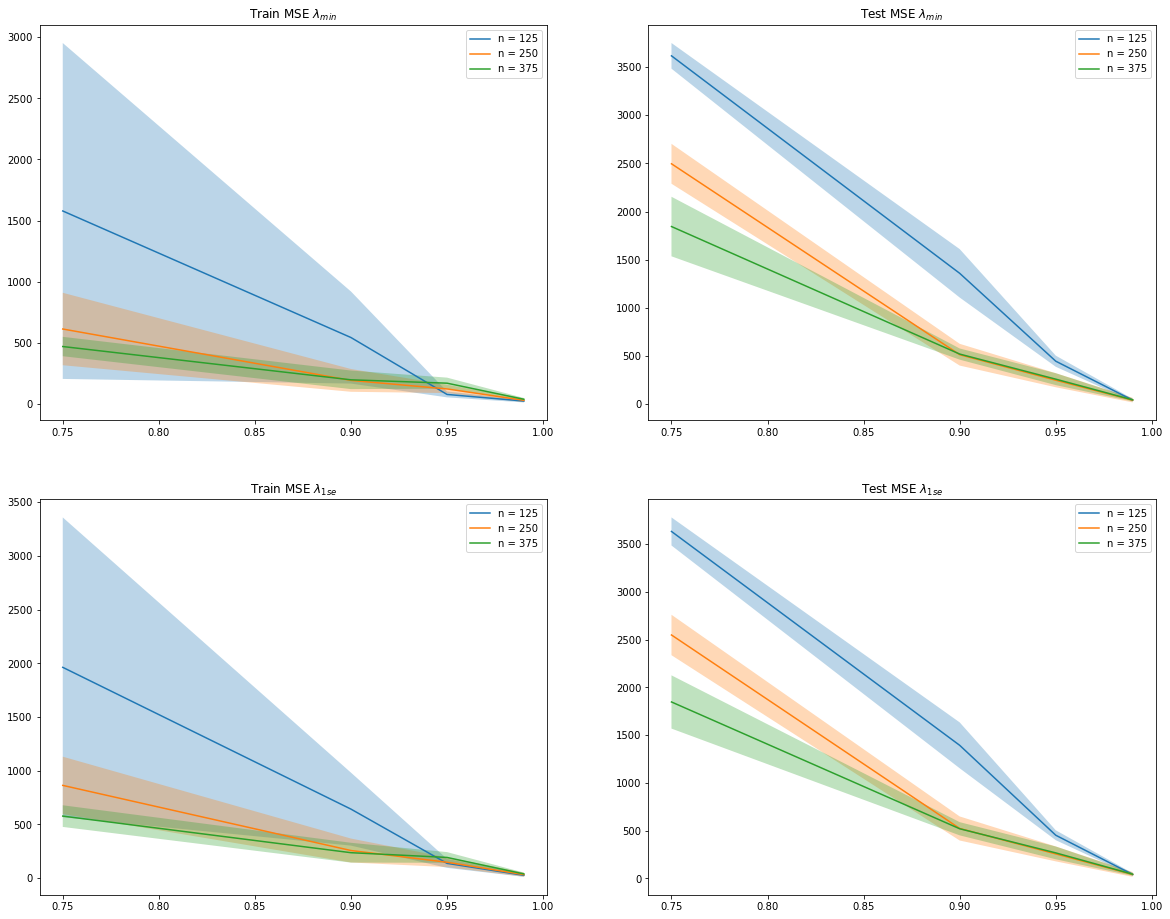

In [125]:
import matplotlib.pyplot as plt
#print(np.mean(test_mse_min, axis=2))
#print(np.mean(test_mse_ose, axis=2))
#print('-----------------------------------')
#print(np.mean(mse_list[col], axis=2))
#print(np.mean(train_mse_ose, axis=2))
#print('===================================')
#print(np.mean(min_precision, axis=2))
#print(np.mean(min_sensitivity, axis=2))

mse_list = [
    [train_mse_min, test_mse_min],
    [train_mse_ose, test_mse_ose]
]

title_list = [
    ['Train MSE $\lambda_{min}$', 'Test MSE $\lambda_{min}$'],
    ['Train MSE $\lambda_{1se}$', 'Test MSE $\lambda_{1se}$']
]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,16))


for row in range(2):
    for col in range(2):
        for n in range(len(n_list)):

            axs[row,col].plot(sparsities, np.mean(mse_list[row][col], axis=2)[n])
            axs[row,col].set_title(title_list[row][col])
            
            axs[row,col].fill_between(
                sparsities, 
                np.mean(mse_list[row][col], axis=2)[n]+np.std(mse_list[row][col], axis=2)[n], 
                np.mean(mse_list[row][col], axis=2)[n]-np.std(mse_list[row][col], axis=2)[n], 
                alpha=0.3
            )
            
        
        axs[row,col].legend(['n = ' + str(label) for label in n_list])




5

### Evaluating the feature selection capability

Compute sensitivity and specificity using the 0-1 codings of the true and estimated coefficient vectors and plot them in a scatter plot.


#### Questions

 - What differences between sensitivity/specificity computed from the $λ_{min}$ and the $λ_{1se}$ models can you observe?
 - How do different choices for n and sparsity affect the relationship of sensitivity/specificity?